# **Movie genre prediction using multi-modal deep learning.**
In this notebook, I try to predict movie genres based on the movie's poster and its overview. The dataset used is Kaggle's rounakbanik/the-movies-dataset. Posters for each film were obtained using the TMDB API and were saved as a normalized numpy array with each element of the array corresponding to a movie. The model used takes the poster as one input along with the overview as another input. The poster in input to a CNN while the overview is input to an LSTM. The output of each network is concatenated. The final fully connected layer consisted of 18 sigmoid output units. Each unit carries the probability of a movie belonging to a particular genre.

This notebook contains a Keras and PyTorch implementation. Keras was primarily used for a baseline model which was then improved using pytorch.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-05-18 05:48:40--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.239.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.239.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  45.4MB/s    in 35s     

2020-05-18 05:49:15 (45.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
!gunzip /content/GoogleNews-vectors-negative300.bin.gz

In [0]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing evaluation metrics

In [0]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [0]:
style.use('seaborn-poster')
style.use('ggplot')

In [0]:
with open('/content/drive/My Drive/Movie_genre_prediction_dataset/train_np_imgs_norm','rb') as f: X_img_train = pickle.load(f)
X_img_train.shape

(26864, 115, 75, 3)

### Loading the image numpy arrays for the train, validation and test set.

In [0]:
with open('/content/drive/My Drive/Movie_genre_prediction_dataset/test_np_imgs_norm', 'rb') as f: X_img_test = pickle.load(f)
X_img_test.shape

(7463, 115, 75, 3)

In [0]:
with open('/content/drive/My Drive/Movie_genre_prediction_dataset/val_np_imgs_norm', 'rb') as f: X_img_val = pickle.load(f)
X_img_val.shape

(2986, 115, 75, 3)

### Loading the overall dataset and the train, test and validation datasets.

In [0]:
dataset = pd.read_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/dataset_mod.csv")
train = pd.read_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/train_data.csv")
test = pd.read_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/test_data.csv")
val = pd.read_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/val_data.csv")

Converting each cell of the genre list column into a list.

In [0]:
dataset['genre_list'] = dataset['genre_list'].apply(lambda x: ast.literal_eval(x))
train['genre_list'] = train['genre_list'].apply(lambda x: ast.literal_eval(x))
test['genre_list'] = test['genre_list'].apply(lambda x: ast.literal_eval(x))
val['genre_list'] = val['genre_list'].apply(lambda x: ast.literal_eval(x))

Evaluating the number of labels per movie in the test, train and validation dataset.

In [0]:
labels = {}

for genre in test['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1

labels

{1: 2533, 2: 2548, 3: 1668, 4: 552, 5: 141, 6: 18, 7: 3}

In [0]:
labels = {}

for genre in train['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1

labels

{1: 8909, 2: 9111, 3: 6158, 4: 2083, 5: 486, 6: 103, 7: 12, 8: 2}

In [0]:
labels = {}

for genre in val['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1

labels

{1: 986, 2: 1021, 3: 686, 4: 234, 5: 48, 6: 11}

### Label generation
Using scikit-learn's Mutltilabel Binarizer to generate one-hot encoded vectors. There are a total of 18 classes and each label is associated with an array index.

In [0]:
mlb = MultiLabelBinarizer()
mlb.fit(dataset['genre_list'].tolist())
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller',
       'War', 'Western'], dtype=object)

In [0]:
transformed_labels = mlb.fit_transform(dataset['genre_list'].tolist())
transformed_labels.shape

(37321, 18)

In [0]:
train_labels = mlb.transform(train['genre_list'].tolist())
train_labels.shape

(26864, 18)

In [0]:
test_labels = mlb.transform(test['genre_list'].tolist())
test_labels.shape

(7463, 18)

In [0]:
val_labels = mlb.transform(val['genre_list'].tolist())
val_labels.shape

(2986, 18)

### Text cleaning
Cleaning the overview of the movies involved getting rid of punctuation, lowering each word, removal of non-alphabetic words and lemmatization.

In [0]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])
  text = re.sub(r"\s{2,}", " ", text)
  return text

train['overview'] = train['overview'].astype(str)
test['overview'] = test['overview'].astype(str)
val['overview'] = val['overview'].astype(str)

train['overview'] = train['overview'].apply(lambda text: clean_text(text))
test['overview'] = test['overview'].apply(lambda text: clean_text(text))
val['overview'] = val['overview'].apply(lambda text: clean_text(text))

In [0]:
dataset['overview'] = dataset['overview'].astype(str)
dataset['overview'] = dataset['overview'].apply(lambda text: clean_text(text))

### The Keras implmentation of the model

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

Using TensorFlow backend.


Fitting the Keras Tokenizer on the entire dataset

In [0]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = dataset['overview'].map(len).max()
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(dataset['overview'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', MAX_SEQUENCE_LENGTH)

Found 71019 unique tokens.
Max len: 868


The baseline model was tested on GLoVe embeddings, fasttext embeddings and word2vec embeddings. Word2vec outperformed the other two embeddings. 

This function loads the word2vec model and intializes the embedding matrix. Each word which is present in the embedding is then added as a vector to the embedding matrix.

In [0]:
def get_embedding_matrix(typeToLoad):
  if typeToLoad == "glove":
    EMBEDDING_FILE="/content/glove.twitter.27B.100d.txt"
    embed_size = 100
  elif typeToLoad == "word2vec":
    word2vecDict = KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True)
    embed_size = 300
  elif typeToLoad == "fasttext":
    EMBEDDING_FILE="/content/wiki-news-300d-1M.vec"
    embed_size = 300

  if typeToLoad == "glove" or typeToLoad == "fasttext":
    embeddings_index = dict()
    f = open(EMBEDDING_FILE)
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
  else:
    embeddings_index = dict()
    for word in word2vecDict.wv.vocab:
      embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
        
  del(embeddings_index)
        
  return embedding_matrix

In [0]:
word2vec_embedding_matrix = get_embedding_matrix("word2vec")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Loaded 3000000 word vectors.
total embedded: 34351 common words


In [0]:
X_text_train = tokenizer.texts_to_sequences(train['overview'].values)
X_text_train = pad_sequences(X_text_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_train.shape)

Shape of train tensor: (26864, 868)


In [0]:
X_text_test = tokenizer.texts_to_sequences(test['overview'].values)
X_text_test = pad_sequences(X_text_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_test.shape)

Shape of train tensor: (7463, 868)


In [0]:
X_text_val = tokenizer.texts_to_sequences(val['overview'].values)
X_text_val = pad_sequences(X_text_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_val.shape)

Shape of train tensor: (2986, 868)


The model architecture consists of an LSTM and a CNN. The LSTM takes the input as a padded sequence of the overview of a movie. The CNN takes a movie poster as the input. Each model has a fully connected layer whose output is concatenated and fed forward to a final fully connected layer with 18 output units. The output layer has a sigmoid activation function.

Binary crossentropy was the chosen loss function and the Adam optimizer was used.

In [0]:
def compile_model(embedding_matrix):
  lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=MAX_SEQUENCE_LENGTH, trainable=False)(lstm_input)
  x = Dropout(0.3)(x)
  x = LSTM(64, return_sequences = True)(x)
  x = Dropout(0.3)(x)
  x = LSTM(64)(x)
  x = Dropout(0.3)(x)
  lstm_out = Dense(18, activation = 'relu')(x)

  print(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
  cnn_input = Input(shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))
  y = Conv2D(32, (3, 3), activation='relu', input_shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))(cnn_input)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(64, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Flatten()(y)
  y = Dropout(0.3)(y)
  cnn_out = Dense(512, activation='relu')(y)

  concat_inp = concatenate([cnn_out, lstm_out])
  z = Dense(256, activation='relu')(concat_inp)
  z = Dropout(0.3)(z)
  z = Dense(128, activation='relu')(z)
  z = Dropout(0.3)(z)
  output = Dense(train_labels.shape[1], activation='sigmoid')(z)

  model = Model(inputs=[cnn_input, lstm_input], outputs=[output])
  adam = Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

In [0]:
word2vec_model = compile_model(word2vec_embedding_matrix)
word2vec_model.summary()

115 75 3
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 115, 75, 3)   0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 113, 73, 32)  896         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 56, 36, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 54, 34, 64)   18496       max_pooling2d_21[0][0]           
___________________________________________________________________________________

Some default Keras callbacks were used to prevent overfitting and saving the model's data and training history.

In [0]:
es = EarlyStopping(patience=5)
csv_logger = CSVLogger('/content/drive/My Drive/Movie_genre_prediction_dataset/model_history_log_model_lstm.csv', append=True)
check_point = ModelCheckpoint(filepath='/content/drive/My Drive/Movie_genre_prediction_dataset/best_lstm_model_todate', save_best_only=True, save_weights_only=True)

In [0]:
word2vec_multi_modal_model = word2vec_model.fit([X_img_train, X_text_train], train_labels, batch_size=256, epochs=20,
                            validation_data=([X_img_val, X_text_val], val_labels), callbacks = [es, csv_logger, check_point])

Train on 26864 samples, validate on 2986 samples
Epoch 1/20
26864/26864 [==============================] - 568s 21ms/step - loss: 0.3500 - accuracy: 0.8692 - val_loss: 0.3108 - val_accuracy: 0.8855
Epoch 2/20
26864/26864 [==============================] - 557s 21ms/step - loss: 0.3146 - accuracy: 0.8832 - val_loss: 0.2969 - val_accuracy: 0.8868
Epoch 3/20
26864/26864 [==============================] - 555s 21ms/step - loss: 0.3052 - accuracy: 0.8856 - val_loss: 0.2931 - val_accuracy: 0.8876
Epoch 4/20
26864/26864 [==============================] - 553s 21ms/step - loss: 0.3017 - accuracy: 0.8865 - val_loss: 0.2922 - val_accuracy: 0.8885
Epoch 5/20
26864/26864 [==============================] - 562s 21ms/step - loss: 0.2975 - accuracy: 0.8876 - val_loss: 0.2887 - val_accuracy: 0.8889
Epoch 6/20
26864/26864 [==============================] - 564s 21ms/step - loss: 0.2947 - accuracy: 0.8885 - val_loss: 0.2858 - val_accuracy: 0.8891
Epoch 7/20
26864/26864 [==============================] -

In [0]:
word2vec_model.save('/content/drive/My Drive/Movie_genre_prediction_dataset/base_model_word2vec_lstm.h5')

In [0]:
word2vec_model = load_model("/content/drive/My Drive/Movie_genre_prediction_dataset/base_model_word2vec_lstm.h5")

In [0]:
def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_acc(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
  plt.show()

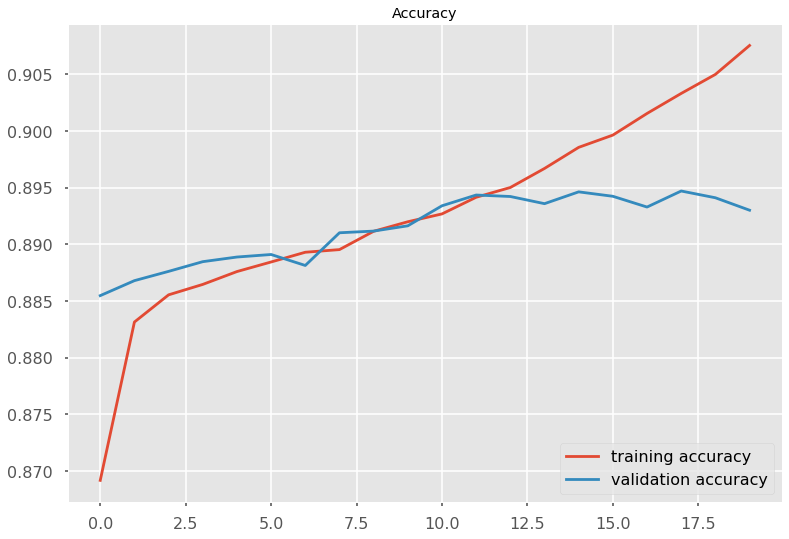

In [0]:
plot_acc(word2vec_multi_modal_model)

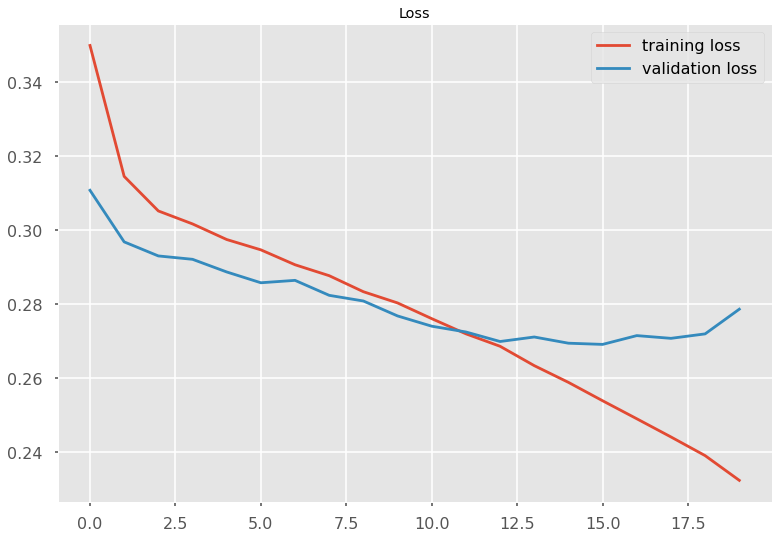

In [0]:
plot_loss(word2vec_multi_modal_model)

Model evaluation on the test set

In [0]:
loss, acc = word2vec_model.evaluate([X_img_test, X_text_test], test_labels, batch_size=256)
print("word2vec model:", loss, acc)

7463/7463 [==============================] - 25s 3ms/step
word2vec model: 0.27427270484564853 0.8949633240699768


In [0]:
out = word2vec_model.predict([X_img_test, X_text_test], batch_size=256)

The primary metric for evaluation was not accuracy due to an imbalance of classes and due to a multi-label output. The ROC AUC score was primarily used to evaluate the model's performance along with the F1 score and Hamming loss.

In [0]:
roc_auc = roc_auc_score(test_labels, out)
print(roc_auc)

0.7563505986434716


Arbitrary threshold of 0.5 to convert the output probabilities for initial evaluation. Evaluation metric are then applied to this one-hot encoded matrix.

In [0]:
y_pred = np.zeros(out.shape)
y_pred[out>0.5]=1
y_pred = np.array(y_pred)

In [0]:
hl = hamming_loss(test_labels,y_pred)
score = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels,y_pred, average = 'samples')
recall = recall_score(test_labels,y_pred, average = 'samples')
f1 = f1_score(test_labels,y_pred, average = 'samples')
print("Hamming loss:", hl)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Hamming loss: 0.10503669956972918
score: 0.15811335923891195
Precision: 0.5170172852740185
Recall: 0.3882837873190278
F1_score: 0.4114172776171972


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using Matthew's correlation coefficient to evaluate the best threshold for each of the 18 classes in the labels.

In [0]:
from sklearn.metrics import matthews_corrcoef
y_test = test_labels
y_pred = np.zeros(out.shape)
y_pred = np.array(y_pred) 
threshold = np.arange(0.01, 0.90, 0.20)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
  y_prob = np.array(out[:,i])
  for j in threshold:
    y_pred = [1 if prob>=j else 0 for prob in y_prob]
    y_pred = np.array(y_pred)
    mcc = matthews_corrcoef(y_test[:,i],y_pred)
    acc.append(mcc)
  acc   = np.array(acc)
  index = np.where(acc==acc.max())
  accuracies.append(acc.max())
  best_threshold[i] = threshold[index[0][0]]
  acc = []

y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
preds = np.transpose(y_pred)
labels = np.transpose(test_labels)

Evaluation of the model's performance for each indivual class. Evaluation metrics are applied to each class label and then the average of these metrics is taken to evaluate the entire model's performance.

Action
accuracy: 0.724373576309795 precision: 0.3262610088070456 recall: 0.6854499579478553 f1: 0.44209384323298073


<Figure size 921.6x633.6 with 0 Axes>

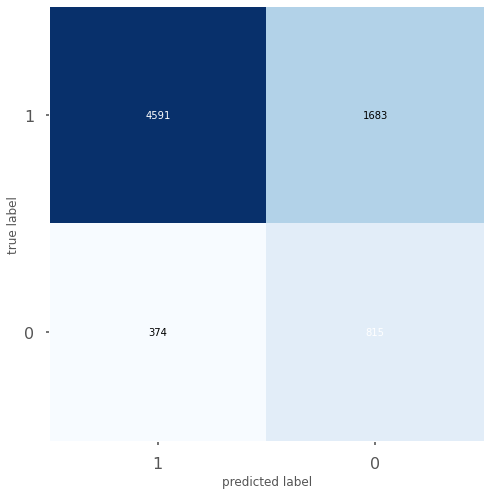

Adventure
accuracy: 0.8753852338201795 precision: 0.2770167427701674 recall: 0.2857142857142857 f1: 0.28129829984544047


<Figure size 921.6x633.6 with 0 Axes>

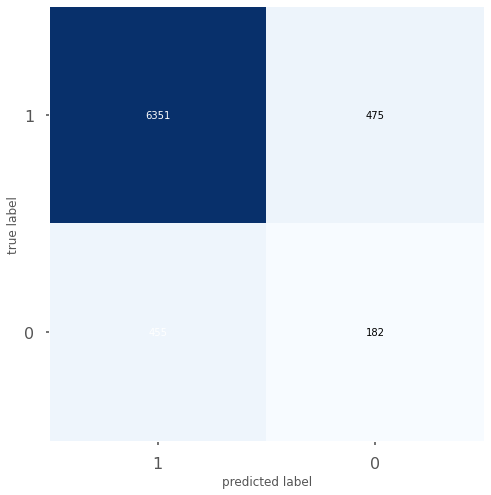

Animation
accuracy: 0.9533699584617447 precision: 0.4927536231884058 recall: 0.2956521739130435 f1: 0.3695652173913043


<Figure size 921.6x633.6 with 0 Axes>

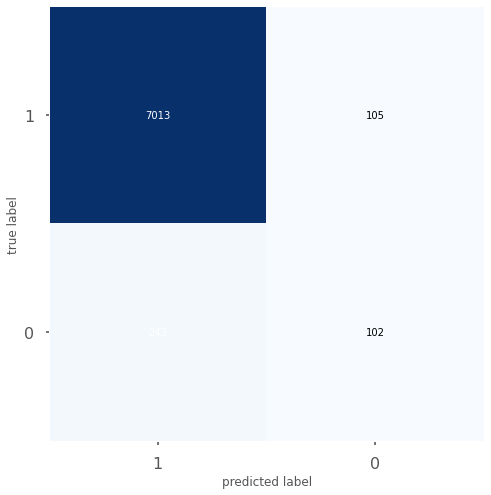

Comedy
accuracy: 0.7237036044486131 precision: 0.5453781512605042 recall: 0.5697980684811238 f1: 0.5573207385143839


<Figure size 921.6x633.6 with 0 Axes>

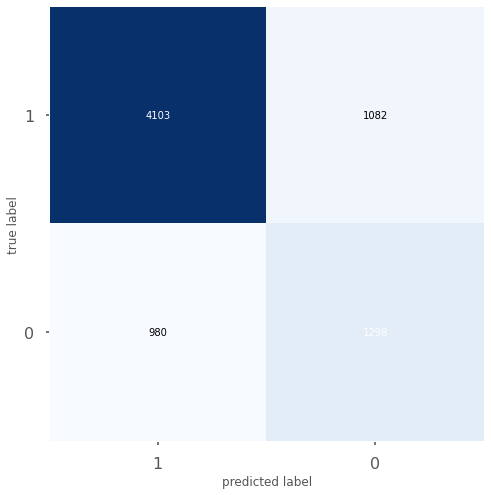

Crime
accuracy: 0.8020903122068873 precision: 0.26515656229180545 recall: 0.5155440414507773 f1: 0.3501979762428509


<Figure size 921.6x633.6 with 0 Axes>

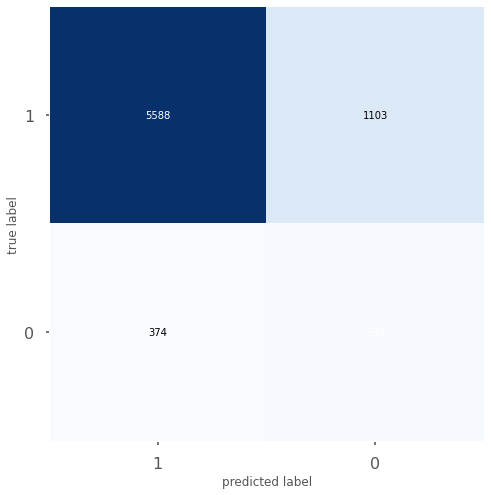

Documentary
accuracy: 0.9497521104113628 precision: 0.7472924187725631 recall: 0.404296875 f1: 0.5247148288973384


<Figure size 921.6x633.6 with 0 Axes>

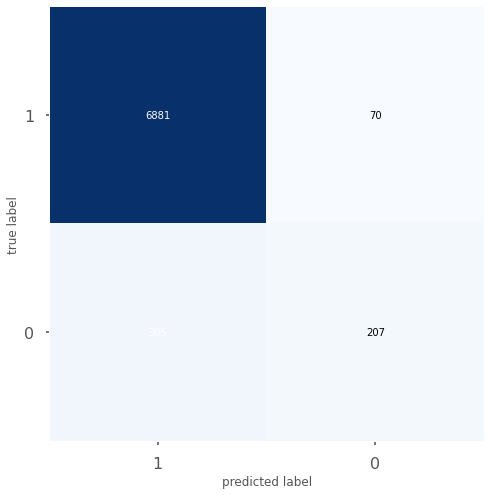

Drama
accuracy: 0.6584483451695029 precision: 0.6784620619258251 recall: 0.5541967759866593 f1: 0.610065779409515


<Figure size 921.6x633.6 with 0 Axes>

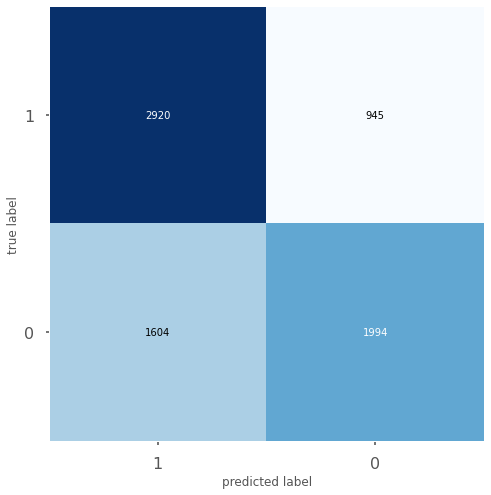

Family
accuracy: 0.924963151547635 precision: 0.47634069400630913 recall: 0.27706422018348625 f1: 0.35034802784222735


<Figure size 921.6x633.6 with 0 Axes>

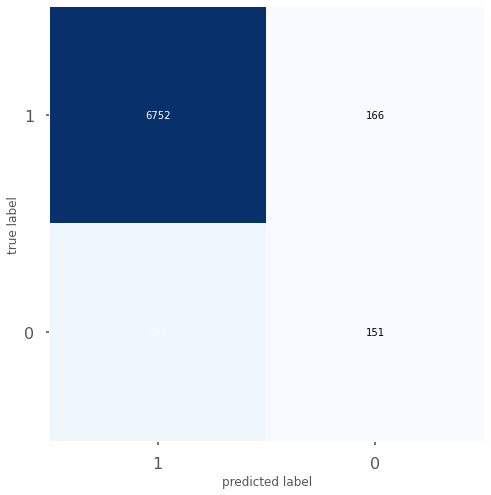

Fantasy
accuracy: 0.9271070615034168 precision: 0.23318385650224216 recall: 0.1223529411764706 f1: 0.16049382716049385


<Figure size 921.6x633.6 with 0 Axes>

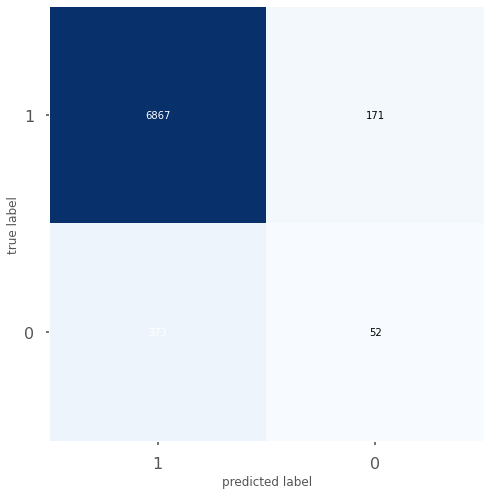

History
accuracy: 0.2476215998928045 precision: 0.04242216900444749 recall: 0.9358490566037736 f1: 0.08116511209294715


<Figure size 921.6x633.6 with 0 Axes>

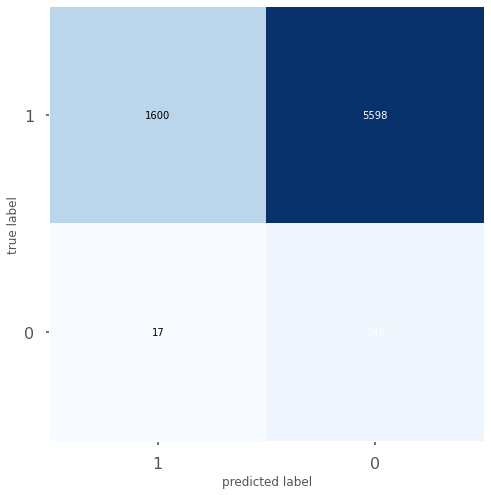

Horror
accuracy: 0.8534101567734155 precision: 0.367487684729064 recall: 0.45212121212121215 f1: 0.40543478260869564


<Figure size 921.6x633.6 with 0 Axes>

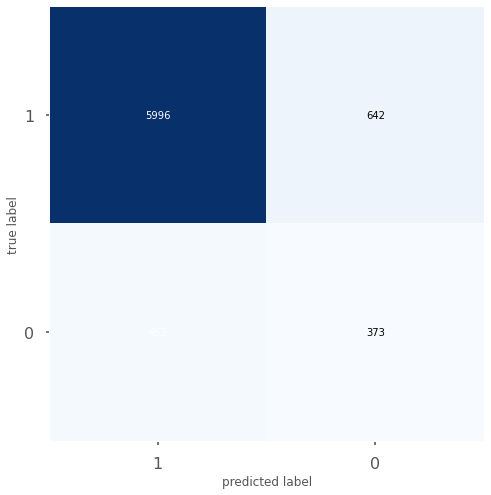

Music
accuracy: 0.26088704274420477 precision: 0.04069158225637443 recall: 0.91015625 f1: 0.0779003677699766


<Figure size 921.6x633.6 with 0 Axes>

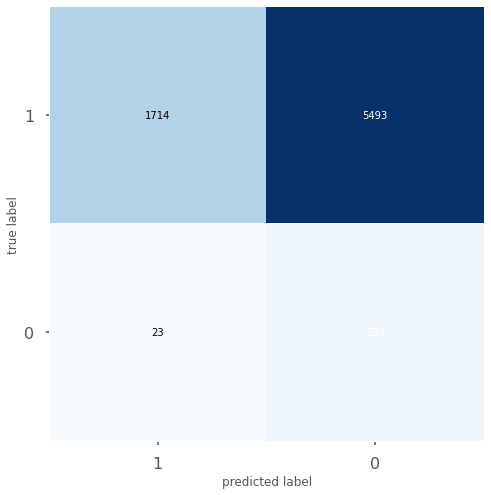

Mystery
accuracy: 0.9035240519898164 precision: 0.22483940042826553 recall: 0.2267818574514039 f1: 0.2258064516129032


<Figure size 921.6x633.6 with 0 Axes>

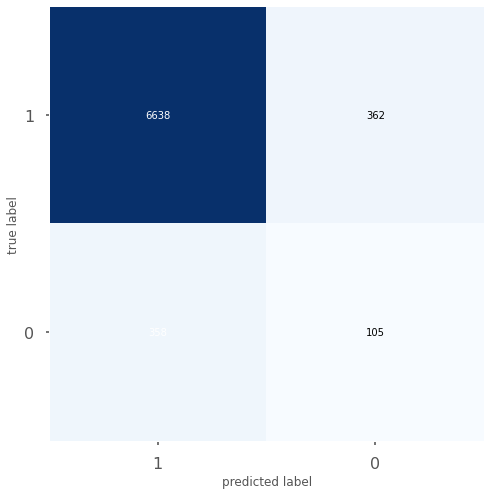

Romance
accuracy: 0.8174996650140695 precision: 0.4273972602739726 recall: 0.38902743142144636 f1: 0.4073107049608355


<Figure size 921.6x633.6 with 0 Axes>

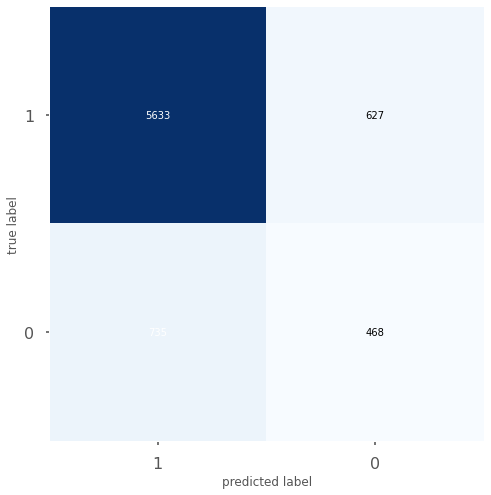

Science Fiction
accuracy: 0.9100897762293984 precision: 0.36401673640167365 recall: 0.32162661737523107 f1: 0.34151128557409227


<Figure size 921.6x633.6 with 0 Axes>

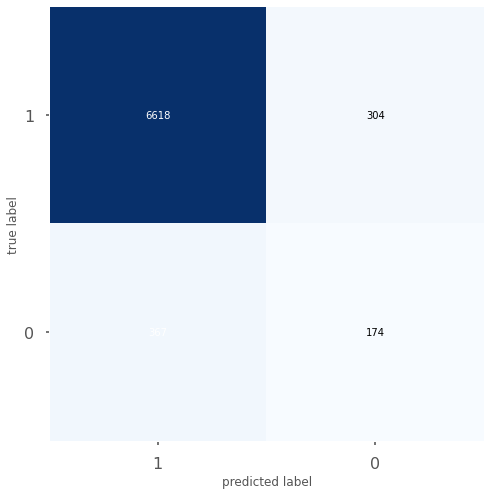

Thriller
accuracy: 0.7105721559694493 precision: 0.3569811320754717 recall: 0.6747503566333809 f1: 0.4669299111549852


<Figure size 921.6x633.6 with 0 Axes>

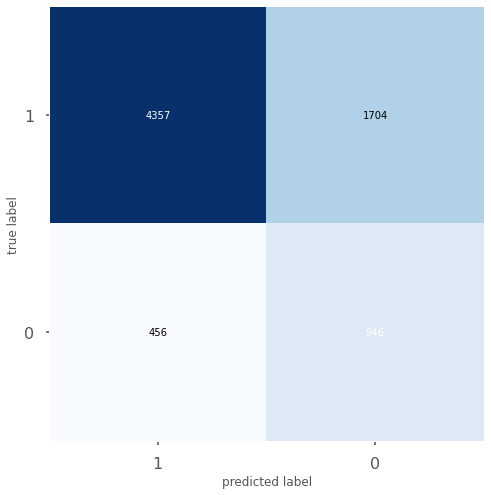

War
accuracy: 0.23073830899102238 precision: 0.03764705882352941 recall: 0.9372384937238494 f1: 0.0723864921635159


<Figure size 921.6x633.6 with 0 Axes>

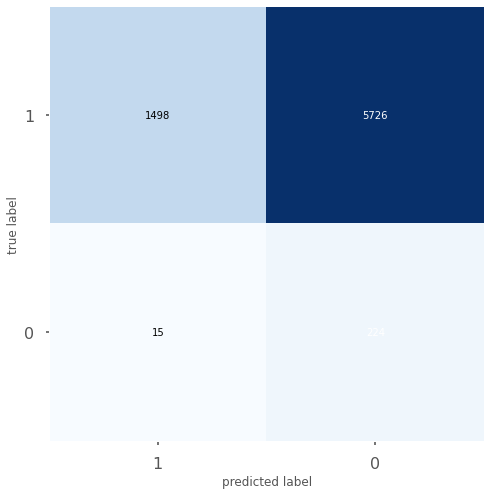

Western
accuracy: 0.9671713788020904 precision: 0.16494845360824742 recall: 0.08888888888888889 f1: 0.11552346570397112


<Figure size 921.6x633.6 with 0 Axes>

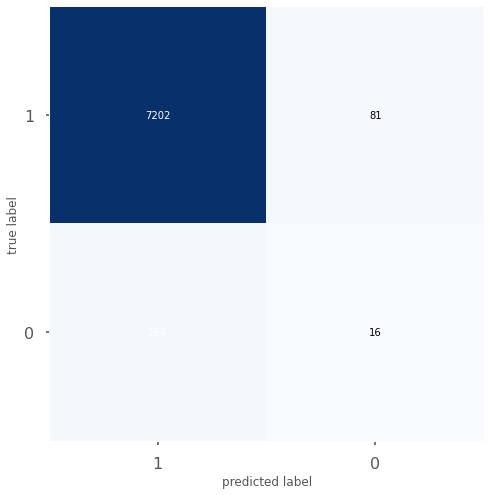

In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(mlb.classes_)
for i in range(labels.shape[0]):
  # print(len(labels[i, :]), len(preds[i, :]))
  accuracy_per_class.append(accuracy_score(labels[i, :], preds[i, :]))
  precision_per_class.append(precision_score(labels[i, :], preds[i, :]))
  recall_per_class.append(recall_score(labels[i, :], preds[i, :]))
  f1_per_class.append(f1_score(labels[i, :], preds[i, :]))
  print(classes[i])
  print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
        "recall:", recall_per_class[i], "f1:", f1_per_class[i])
  cm  = confusion_matrix(labels[i, :], preds[i, :])
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(2), ['1', '0'], fontsize=16)
  plt.yticks(range(2), ['1', '0'], fontsize=16)
  plt.show()

In [0]:
print("Acc:", np.mean(accuracy_per_class), "Precision:", np.mean(precision_per_class), "Recall:",
      np.mean(recall_per_class), "f1:", np.mean(f1_per_class))

Acc: 0.7467059716825226 Precision: 0.3371264776181064 Recall: 0.48036163911516044 f1: 0.3244481728988032


### Pytorch implementation of the model

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
# del model
torch.cuda.empty_cache()

Reshaping numpy arrays containing image data to change it into (number of images * channels * width * height). 

In [0]:
X_img_val = np.reshape(X_img_val, (X_img_val.shape[0], 3, 75, 115))
X_img_val.shape

(2986, 3, 75, 115)

In [0]:
X_img_test = np.reshape(X_img_test, (X_img_test.shape[0], 3, 75, 115))

In [0]:
X_img_train = np.reshape(X_img_train, (X_img_train.shape[0], 3, 75, 115))

Creating data loaders for the text and image inputs for the train, validation and test sets.

In [0]:
text_train_data = TensorDataset(torch.from_numpy(X_text_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(torch.from_numpy(X_img_train), torch.from_numpy(train_labels))

text_val_data = TensorDataset(torch.from_numpy(X_text_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(torch.from_numpy(X_img_val), torch.from_numpy(val_labels))

text_test_data = TensorDataset(torch.from_numpy(X_text_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(torch.from_numpy(X_img_test), torch.from_numpy(test_labels))

batch_size = 64

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))
print(len(text_test_loader), len(img_test_loader))

420 420
47 47
117 117


The model consisting of a CNN and LSTM with their outputs being fed into a set of fully connected layers. The final layer consists of 18 output units each having a sigmoid activation. 

In [0]:
class CNN_LSTM(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(CNN_LSTM, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)
    # self.sigmoid = nn.Sigmoid()

    # CNN for the posters
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5*2*128, 512)

    # Concat layer for the combined feature space
    self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_out)


  def forward(self, lstm_inp, cnn_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))

    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5*2*128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))

    combined_inp = torch.cat((cnn_out, lstm_out), 1)
    x_comb = F.relu(self.combined_fc1(combined_inp))
    x_comb = F.relu(self.combined_fc2(x_comb))
    out = torch.sigmoid(self.output_fc(x_comb))

    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
    return hidden

Defining the hyperparameters of the model along with defining the optimizer and loss function. Similar to Keras, the binary cross entropy loss is used. In order to fine tune the model, the embedding layer which has teh word2vec embedding is also trainable. This was done as a significant amount of words were not present in the word2vec vocab.

In [0]:
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2
print(output_size)

model = CNN_LSTM(vocab_size, word2vec_embedding_matrix, hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

18
CNN_LSTM(
  (emb): Embedding(71020, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=1280, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, 

Training and validation of the model. A batchsize of 64 is used to prevent an out of memory error.

In [0]:
epochs = 20
clip = 5

model.train()
for i in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
    
  for lstm, cnn in zip(text_train_loader, img_train_loader):
    lstm_inp, lstm_labels = lstm
    cnn_inp, cnn_labels = cnn
    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
    cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
    model.zero_grad()
    output = model(lstm_inp, cnn_inp)
    loss = criterion(output.squeeze(), lstm_labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
    with torch.no_grad():
      acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc
      total_loss_train += loss.item()
  
  train_acc = total_acc_train/len(text_train_loader)
  train_loss = total_loss_train/len(text_train_loader)
  model.eval()
  total_acc_val = 0
  total_loss_val = 0
  with torch.no_grad():
    for lstm, cnn in zip(text_val_loader, img_val_loader):
      lstm_inp, lstm_labels = lstm
      cnn_inp, cnn_labels = cnn
      lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
      cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
      model.zero_grad()
      output = model(lstm_inp, cnn_inp)
      val_loss = criterion(output.squeeze(), lstm_labels.float())
      acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_val += acc
      total_loss_val += val_loss.item()
    print("Saving model...") 
    torch.save(model.state_dict(), '/content/drive/My Drive/Movie_genre_prediction_dataset/pytorch_word2vec_lstm_less_dropout.pt')

  val_acc = total_acc_val/len(text_val_loader)
  val_loss = total_loss_val/len(text_val_loader)
  print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
  model.train()
  torch.cuda.empty_cache()

Saving model...
Epoch 1: train_loss: 0.3175 train_acc: 0.8131 | val_loss: 0.3025 val_acc: 0.8127
Saving model...
Epoch 2: train_loss: 0.2911 train_acc: 0.8280 | val_loss: 0.2851 val_acc: 0.8202
Saving model...
Epoch 3: train_loss: 0.2763 train_acc: 0.8351 | val_loss: 0.2770 val_acc: 0.8248
Saving model...
Epoch 4: train_loss: 0.2630 train_acc: 0.8414 | val_loss: 0.2709 val_acc: 0.8367
Saving model...
Epoch 5: train_loss: 0.2501 train_acc: 0.8487 | val_loss: 0.2667 val_acc: 0.8424
Saving model...
Epoch 6: train_loss: 0.2370 train_acc: 0.8568 | val_loss: 0.2679 val_acc: 0.8419
Saving model...
Epoch 7: train_loss: 0.2252 train_acc: 0.8646 | val_loss: 0.2665 val_acc: 0.8469
Saving model...
Epoch 8: train_loss: 0.2151 train_acc: 0.8712 | val_loss: 0.2693 val_acc: 0.8547
Saving model...
Epoch 9: train_loss: 0.2049 train_acc: 0.8776 | val_loss: 0.2696 val_acc: 0.8565
Saving model...
Epoch 10: train_loss: 0.1976 train_acc: 0.8821 | val_loss: 0.2805 val_acc: 0.8623
Saving model...
Epoch 11: tra

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/Movie_genre_prediction_dataset/pytorch_word2vec_less_dropout.pt')

Testing the model

In [0]:
model.eval()
total_acc_test = 0
total_loss_test = 0
outputs = []
with torch.no_grad():
  for lstm, cnn in zip(text_test_loader, img_test_loader):
    lstm_inp, lstm_labels = lstm
    cnn_inp, cnn_labels = cnn
    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
    cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
    out = model(lstm_inp, cnn_inp)
    outputs += list(out.cpu().data.numpy())
    loss = criterion(out.squeeze(), lstm_labels.float())
    acc = torch.abs(out.squeeze() - lstm_labels.float()).view(-1)
    acc = (1. - acc.sum() / acc.size()[0])
    total_acc_test += acc
    total_loss_test += loss.item()

acc_test = total_acc_test/len(text_test_loader)
loss_test = total_loss_test/len(text_test_loader)
print(f'acc: {acc_test:.4f} loss: {loss_test:.4f}')

acc: 0.8737 loss: 0.3406


In [0]:
np_out = np.array(outputs)

In [0]:
y_pred = np.zeros(np_out.shape)
y_pred[np_out>0.5]=1
y_pred = np.array(y_pred)

In [0]:
print(recall_score(test_labels, y_pred, average="samples"))
print(precision_score(test_labels, y_pred, average="samples"))
print(f1_score(test_labels, y_pred, average="samples"))
print(hamming_loss(test_labels, y_pred))
print(accuracy_score(test_labels, y_pred))

0.5210588107680431
0.5731609272410558
0.508094536219955
0.10782824899132014
0.1654830497119121


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
roc_auc = roc_auc_score(test_labels, np_out)
print(roc_auc)

0.8021169393170184


In [0]:
from sklearn.metrics import matthews_corrcoef
y_test = test_labels
y_pred = np.zeros(np_out.shape)
y_pred = np.array(y_pred) 
threshold = np.arange(0.01, 0.90, 0.10)

acc = []
accuracies = []
best_threshold = np.zeros(np_out.shape[1])
for i in range(np_out.shape[1]):
  y_prob = np.array(np_out[:,i])
  for j in threshold:
    y_pred = [1 if prob>=j else 0 for prob in y_prob]
    y_pred = np.array(y_pred)
    mcc = matthews_corrcoef(y_test[:, i], y_pred)
    acc.append(mcc)
  acc   = np.array(acc)
  index = np.where(acc==acc.max())
  accuracies.append(acc.max())
  best_threshold[i] = threshold[index[0][0]]
  acc = []

y_pred = np.array([[1 if np_out[i,j]>=best_threshold[j] else 0 for j in range(test_labels.shape[1])] for i in range(len(test_labels))])   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
preds = np.transpose(y_pred)
labels = np.transpose(test_labels)

Action
accuracy: 0.8187056143641968 precision: 0.4477707006369427 recall: 0.5912531539108494 f1: 0.5096049293222182


<Figure size 921.6x633.6 with 0 Axes>

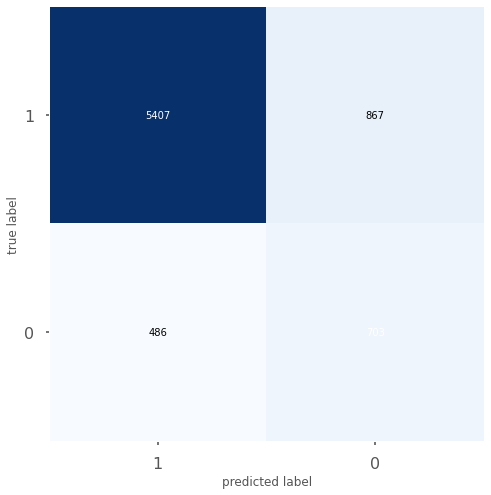

Adventure
accuracy: 0.8913305641163071 precision: 0.355 recall: 0.33437990580847726 f1: 0.34438156831042843


<Figure size 921.6x633.6 with 0 Axes>

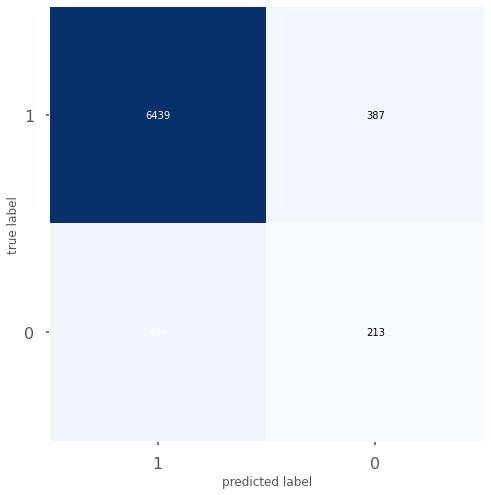

Animation
accuracy: 0.9244271740586896 precision: 0.31719532554257096 recall: 0.5507246376811594 f1: 0.4025423728813559


<Figure size 921.6x633.6 with 0 Axes>

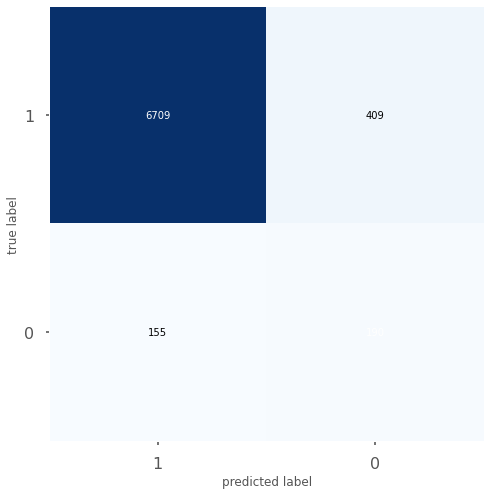

Comedy
accuracy: 0.7452766983786681 precision: 0.5772857728577285 recall: 0.6180860403863038 f1: 0.5969896120415518


<Figure size 921.6x633.6 with 0 Axes>

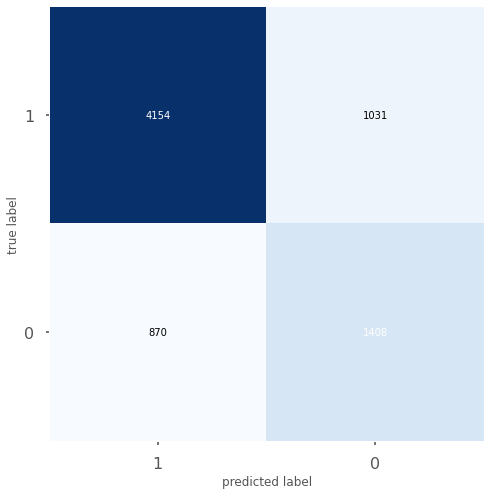

Crime
accuracy: 0.8455044888114699 precision: 0.34295136026380874 recall: 0.538860103626943 f1: 0.41914357682619646


<Figure size 921.6x633.6 with 0 Axes>

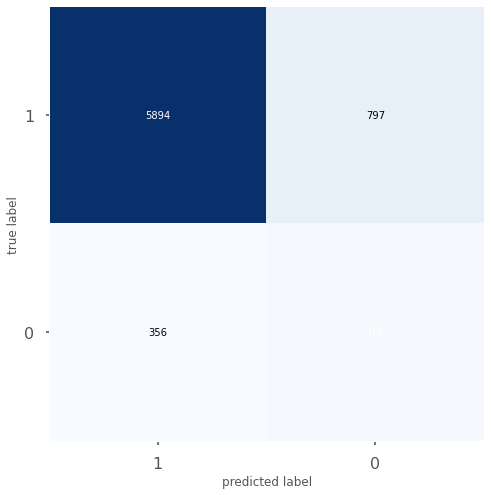

Documentary
accuracy: 0.9493501272946536 precision: 0.6536697247706422 recall: 0.556640625 f1: 0.6012658227848101


<Figure size 921.6x633.6 with 0 Axes>

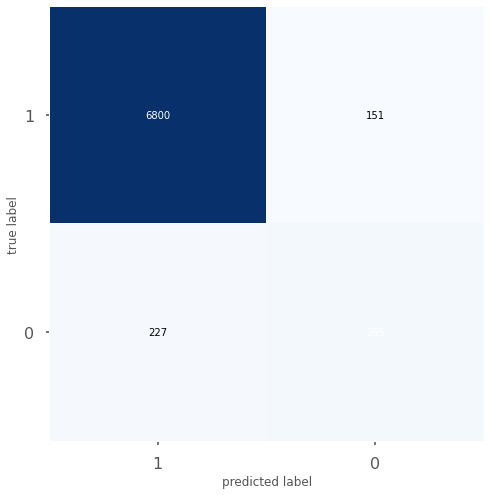

Drama
accuracy: 0.6733217204877395 precision: 0.708183776022972 recall: 0.5483602001111729 f1: 0.6181077694235589


<Figure size 921.6x633.6 with 0 Axes>

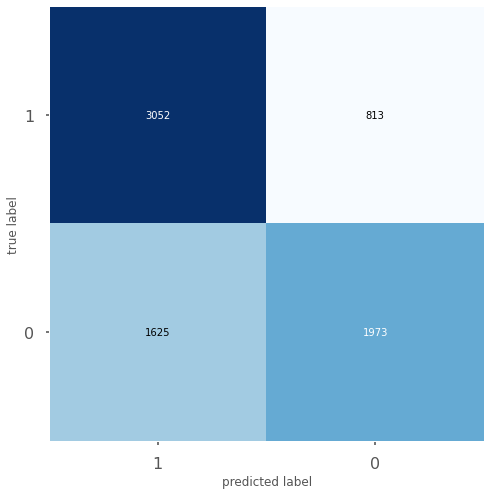

Family
accuracy: 0.9193353879137076 precision: 0.43817787418655096 recall: 0.3706422018348624 f1: 0.4015904572564612


<Figure size 921.6x633.6 with 0 Axes>

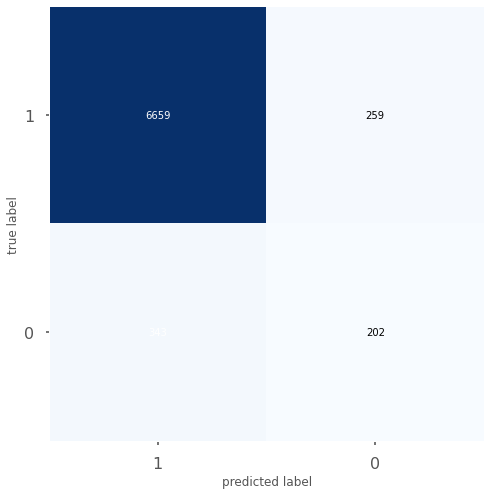

Fantasy
accuracy: 0.9173254723301622 precision: 0.2818181818181818 recall: 0.2917647058823529 f1: 0.28670520231213875


<Figure size 921.6x633.6 with 0 Axes>

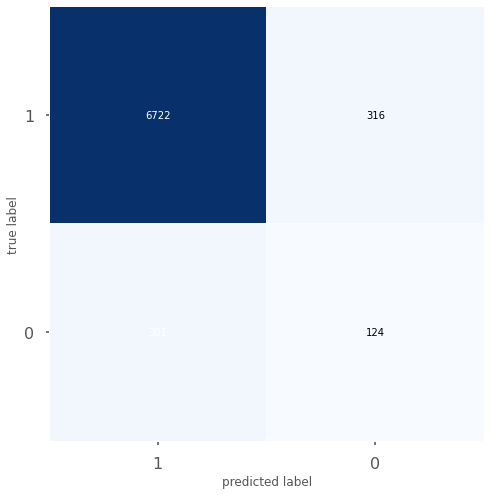

History
accuracy: 0.9308589039260351 precision: 0.19464720194647203 recall: 0.3018867924528302 f1: 0.2366863905325444


<Figure size 921.6x633.6 with 0 Axes>

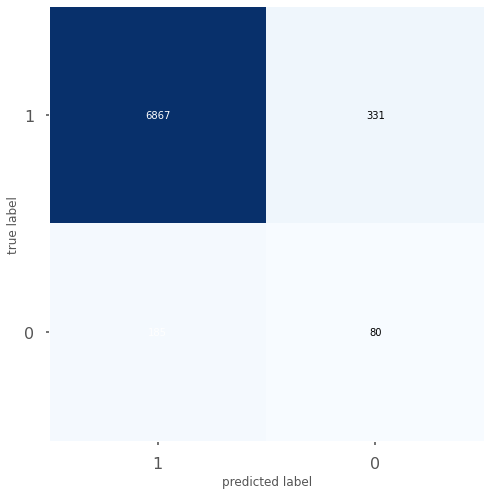

Horror
accuracy: 0.9082138550180893 precision: 0.5862068965517241 recall: 0.576969696969697 f1: 0.5815516188149054


<Figure size 921.6x633.6 with 0 Axes>

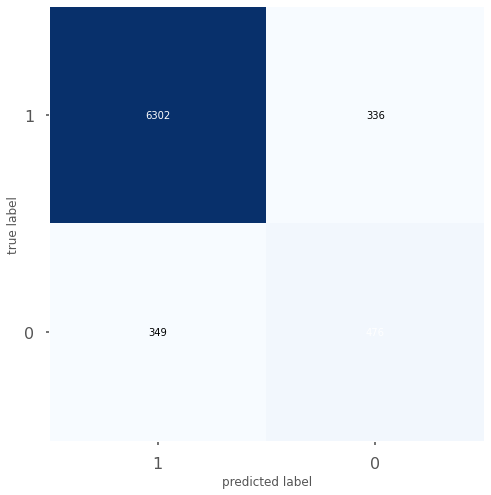

Music
accuracy: 0.9584617446067265 precision: 0.3333333333333333 recall: 0.2109375 f1: 0.2583732057416268


<Figure size 921.6x633.6 with 0 Axes>

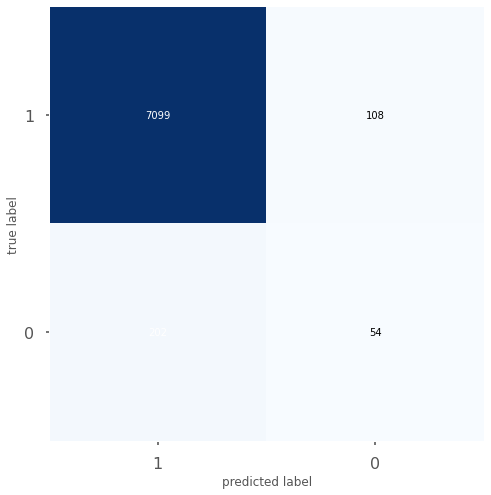

Mystery
accuracy: 0.8752512394479431 precision: 0.22274881516587677 recall: 0.4060475161987041 f1: 0.287681713848508


<Figure size 921.6x633.6 with 0 Axes>

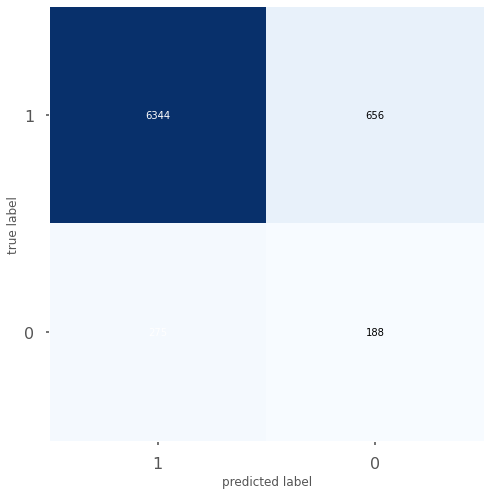

Romance
accuracy: 0.8073160927241055 precision: 0.40562248995983935 recall: 0.4197838736492103 f1: 0.4125816993464052


<Figure size 921.6x633.6 with 0 Axes>

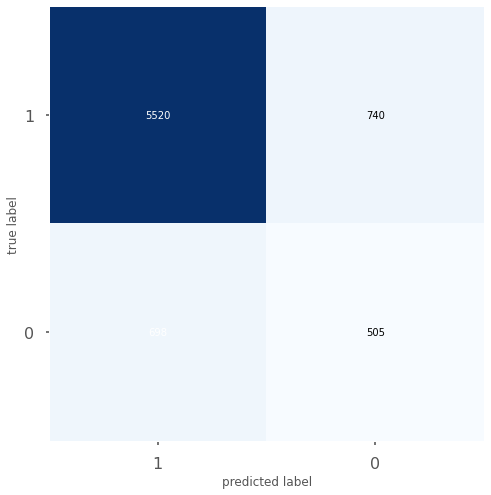

Science Fiction
accuracy: 0.934476751976417 precision: 0.5643564356435643 recall: 0.4214417744916821 f1: 0.4825396825396825


<Figure size 921.6x633.6 with 0 Axes>

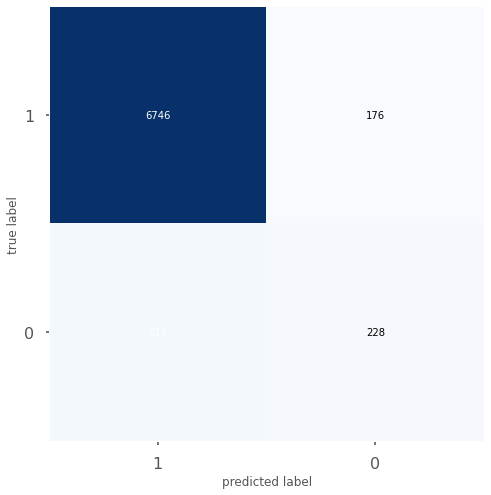

Thriller
accuracy: 0.8074500870963419 precision: 0.48840291583830353 recall: 0.5256776034236804 f1: 0.5063552043971143


<Figure size 921.6x633.6 with 0 Axes>

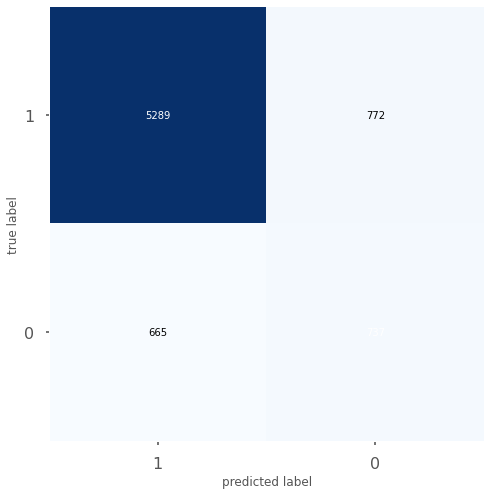

War
accuracy: 0.9537719415784537 precision: 0.32450331125827814 recall: 0.4100418410041841 f1: 0.3622920517560074


<Figure size 921.6x633.6 with 0 Axes>

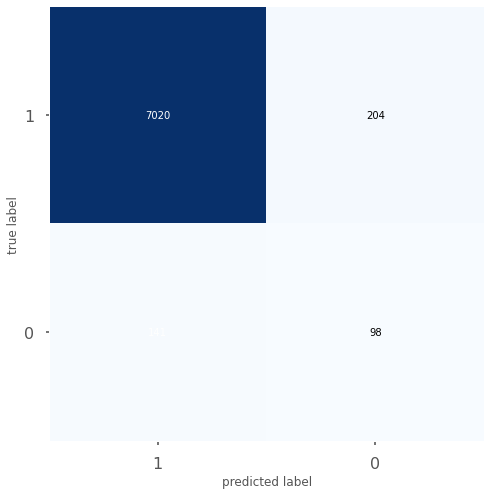

Western
accuracy: 0.9796328554200724 precision: 0.675 recall: 0.3 f1: 0.41538461538461535


<Figure size 921.6x633.6 with 0 Axes>

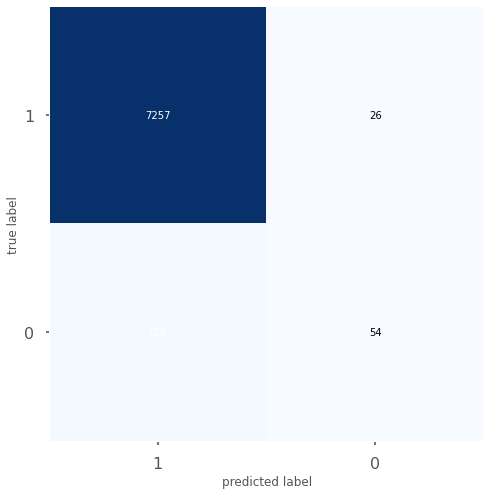

In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(mlb.classes_)
for i in range(labels.shape[0]):
  # print(len(labels[i, :]), len(preds[i, :]))
  accuracy_per_class.append(accuracy_score(labels[i, :], preds[i, :]))
  precision_per_class.append(precision_score(labels[i, :], preds[i, :]))
  recall_per_class.append(recall_score(labels[i, :], preds[i, :]))
  f1_per_class.append(f1_score(labels[i, :], preds[i, :]))
  print(classes[i])
  print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
        "recall:", recall_per_class[i], "f1:", f1_per_class[i])
  cm  = confusion_matrix(labels[i, :], preds[i, :])
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(2), ['1', '0'], fontsize=16)
  plt.yticks(range(2), ['1', '0'], fontsize=16)
  plt.show()

In [0]:
print("Acc:", np.mean(accuracy_per_class), "Precision:", np.mean(precision_per_class), "Recall:",
      np.mean(recall_per_class), "f1:", np.mean(f1_per_class))

Acc: 0.8800005955305433 Precision: 0.4398263397664883 Recall: 0.4429721206906727 f1: 0.4290987496400072


### Conclusion

In conclusion, the fine-tuned Pytorch was able to outperform the baseline model. While looking at just the accruacy and loss of the model on the test set batches, the Keras baseline model does seem to outperform the fine tuned model. However, our primary evaluation metrics included ROC AUC score, hamming loss and the F1 score.

| Model | Test acc and loss | ROC AUC score | F1, Recall and Precision | Hamming loss |
| ----- | ----------------- | ------------- | ------------------------ | |
|Keras baseline|0.8950, 0.2743|0.7563|0.4114, 0.3882, 0.5170|0.1050|
|Pytorch fine tuned|0.8737, 0.3406|0.8021|0.5081, 0.5731, 0.5211|0.1078|


---


| Model | Avg acc per class | Avg F1 per class | Avg recall per class | Avg precision per class |
| ----- | ----------------- | ---------------- | -------------------- | ------------------- |
|Keras baseline|0.7467|0.3244|0.4804|0.3371|
|Pytorch fine tuned|0.8800|0.4291|0.4430|0.4398|

